In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import humanize
import plotly.express as px
import warnings
import pymongo
import os

In [2]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80
warnings.filterwarnings('ignore')

In [3]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]

# apartments.head(3)

In [4]:
# apartments = pd.read_csv('../../data/processed/apartments.csv', low_memory=False)
fontibon =  apartments[(apartments['tipo_operacion'] == 'VENTA') & (apartments['localidad'] == 'FONTIBON') & (apartments['coords_modified'] == False)]
fontibon = fontibon.drop(columns=['precio_arriendo'])
fontibon.head()

,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,...,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm
15,10159-M4313732,APARTAMENTO,VENTA,6.530000e+08,88.93,3.0,3.0,320000.0,1.0,SALITRE MODELIA,...,0.0,1.0,1.0,0.0,False,FONTIBON,LA ESPERANZA_,Normandía,1510.38,0
23,13294-M4320632,APARTAMENTO,VENTA,5.000000e+08,87.00,3.0,2.0,350000.0,1.0,FONTIBON TINTAL,...,0.0,1.0,1.0,0.0,False,FONTIBON,URB. PRADO GRANDE,Modelia,2331.53,0
43,234-M4423073,APARTAMENTO,VENTA,4.320000e+08,60.00,3.0,2.0,380000.0,1.0,SALITRE MODELIA,...,0.0,1.0,1.0,1.0,False,FONTIBON,MODELIA,Normandía,454.61,1
55,10159-M3528801,APARTAMENTO,VENTA,1.900000e+09,242.00,4.0,4.0,720000.0,3.0,SALITRE MODELIA,...,0.0,1.0,1.0,1.0,False,FONTIBON,CAMAVIEJA,Normandía,144.84,1
65,533-M4332269,APARTAMENTO,VENTA,1.150000e+09,138.00,3.0,4.0,700000.0,2.0,SALITRE MODELIA,...,0.0,1.0,1.0,1.0,False,FONTIBON,LA ESPERANZA NORTE,AV. Rojas,575.30,0


In [5]:
fontibon.datetime = pd.to_datetime(fontibon.datetime)
fontibon.fecha_actualizacion_precio_venta = pd.to_datetime(fontibon.fecha_actualizacion_precio_venta)

In [6]:
fontibon.shape

(1987, 39)

In [7]:
fontibon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 15 to 84740
Data columns (total 39 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   codigo                               1987 non-null   object        
 1   tipo_propiedad                       1987 non-null   object        
 2   tipo_operacion                       1987 non-null   object        
 3   precio_venta                         1987 non-null   float64       
 4   area                                 1987 non-null   float64       
 5   habitaciones                         1987 non-null   float64       
 6   banos                                1987 non-null   float64       
 7   administracion                       1781 non-null   float64       
 8   parqueaderos                         1987 non-null   float64       
 9   sector                               1803 non-null   object        
 10  estrato        

In [8]:
fontibon.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'estado', 'longitud', 'latitud', 'descripcion',
       'datetime', 'website', 'compañia', 'last_view',
       'fecha_actualizacion_precio_venta', 'precio_venta_anterior',
       'fecha_actualizacion_precio_arriendo', 'precio_arriendo_anterior',
       'direccion', 'jacuzzi', 'piso', 'closets', 'chimenea',
       'permite_mascotas', 'gimnasio', 'ascensor', 'conjunto_cerrado',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm'],
      dtype='object')

In [9]:
def format_tick_humanize(value, tick_number):
    return humanize.intword(value)

# Eliminar outliers

Eliminamos los precios que son outliers

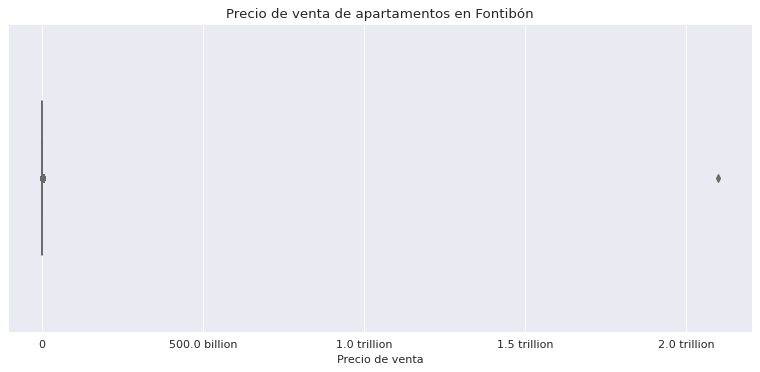

In [10]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    fontibon,
    x='precio_venta',
    width=.5,
    palette='Set3',
)

plt.title('Precio de venta de apartamentos en Fontibón')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [11]:
Q1 = fontibon['precio_venta'].quantile(0.25)
Q3 = fontibon['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
if lower < 0:
    lower = Q1 - (0.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = fontibon[(fontibon['precio_venta'] < lower) | (fontibon['precio_venta'] > upper)]
outliers.shape

(119, 39)

In [12]:
fontibon = fontibon[(fontibon['precio_venta'] > lower) & (fontibon['precio_venta'] < upper)]
fontibon.shape

(1866, 39)

# Analisis Univariado

## Area (m2)

### Eliminar outliers

In [13]:
# eliminar area igual a 0

fontibon = fontibon[fontibon['area'] > 0]

Eliminamos las areas (m2) que son outliers

In [14]:
Q1 = fontibon['area'].quantile(0.25)
Q3 = fontibon['area'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = fontibon[(fontibon['area'] < lower) | (fontibon['area'] > upper)]
outliers.shape

(79, 39)

In [15]:
fontibon = fontibon[(fontibon['area'] > lower) & (fontibon['area'] < upper)]
fontibon.shape

(1783, 39)

### Analisis

In [16]:
fontibon.area.describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
area,"1,783.0",68.0691475042064,19.138158768442995,19.9,53.0,65.0,82.0,128.56


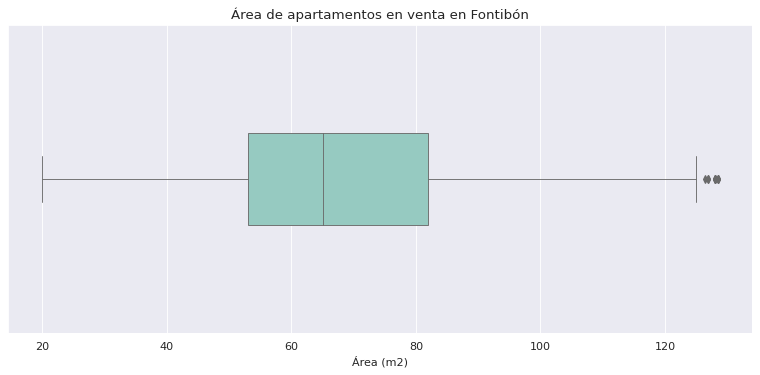

In [17]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=fontibon,
    x='area',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Área de apartamentos en venta en Fontibón')
plt.xlabel('Área (m2)')
plt.show()

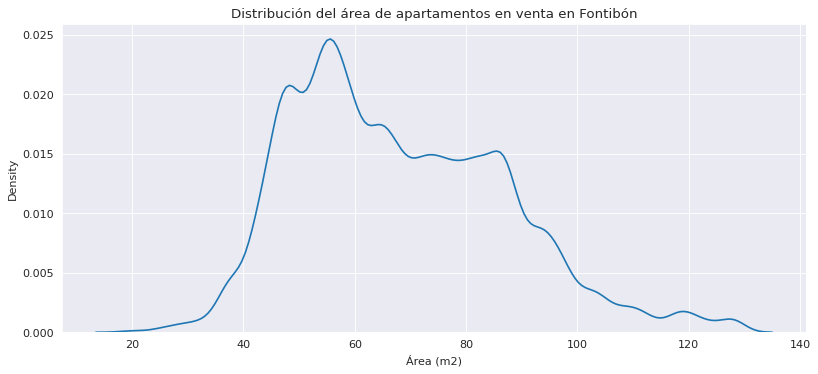

In [18]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='area',
    bw_adjust=.5,
)

plt.title('Distribución del área de apartamentos en venta en Fontibón')
plt.xlabel('Área (m2)')
plt.show()

### Cercania a Transmilenio

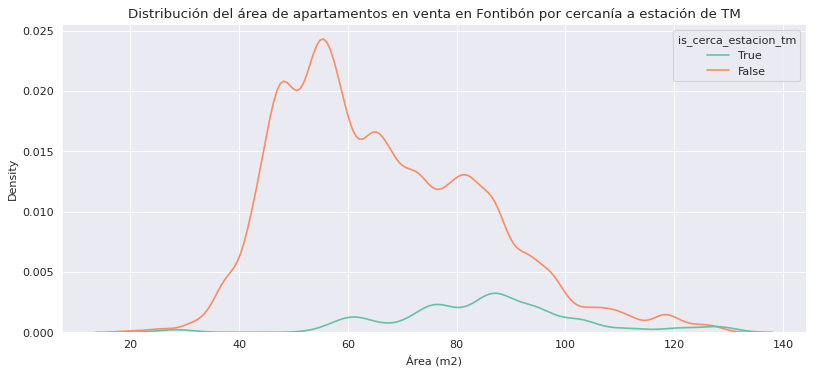

In [19]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='area',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('Distribución del área de apartamentos en venta en Fontibón por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.show()

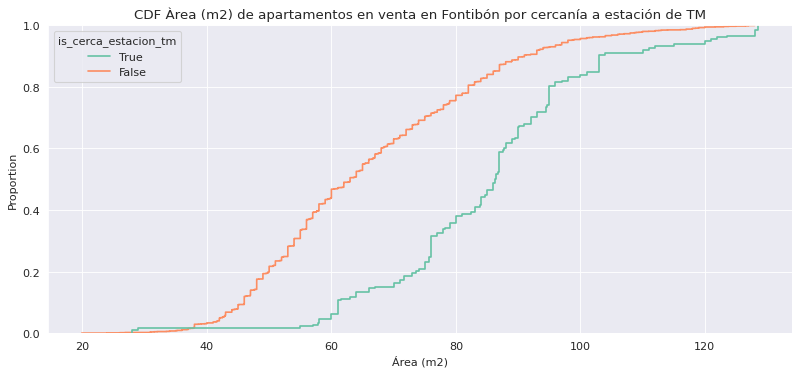

In [20]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='area',
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('CDF Àrea (m2) de apartamentos en venta en Fontibón por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.show()


### Estrato

In [21]:
fontibon.groupby('estrato')['area'].describe().applymap(lambda x: round(x, 1))

,count,mean,std,min,25%,50%,75%,max
estrato,,,,,,,,
1.0,1.0,49.0,NaN,49.0,49.0,49.0,49.0,49.0
2.0,126.0,49.0,6.8,24.0,46.0,49.8,54.0,69.0
3.0,533.0,55.4,12.0,19.9,48.0,53.0,60.0,110.0
4.0,1007.0,75.1,17.1,26.9,63.0,74.0,87.0,127.0
5.0,115.0,86.8,21.6,40.0,72.0,86.5,99.0,128.6


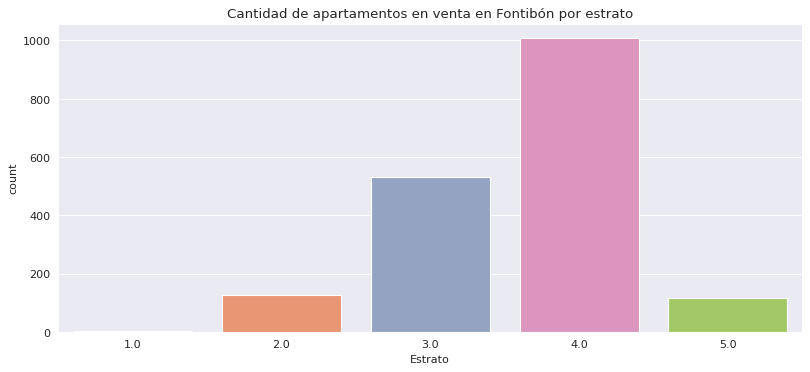

In [22]:
plt.figure(figsize=(12, 5))

sns.countplot(
    data=fontibon,
    x='estrato',
    palette='Set2',
)

plt.title('Cantidad de apartamentos en venta en Fontibón por estrato')
plt.xlabel('Estrato')
plt.show()

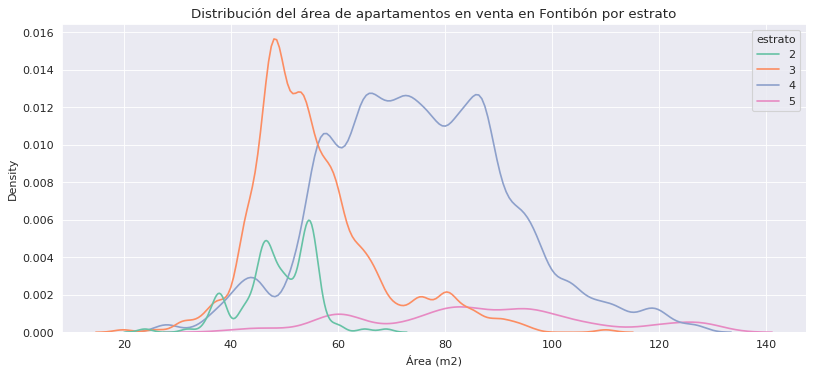

In [23]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='area',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[2, 3, 4, 5],
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en venta en Fontibón por estrato')
plt.xlabel('Área (m2)')
plt.show()

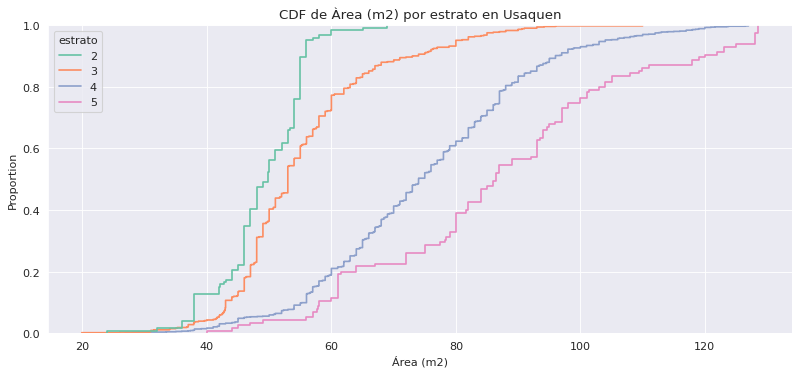

In [24]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='area',
    hue='estrato',
    palette='Set2',
    hue_order=[2, 3, 4, 5],
)

plt.title('CDF de Àrea (m2) por estrato en Usaquen')
plt.xlabel('Área (m2)')
plt.show()

### Antiguedad

In [25]:
fontibon.groupby('antiguedad')['area'].describe().applymap(lambda x: round(x, 1))

,count,mean,std,min,25%,50%,75%,max
antiguedad,,,,,,,,
ENTRE 0 Y 5 ANOS,563.0,60.7,17.6,19.9,47.1,56.0,73.0,118.0
ENTRE 10 Y 20 ANOS,449.0,72.4,19.7,36.0,58.0,69.0,87.0,128.6
ENTRE 5 Y 10 ANOS,355.0,69.7,18.4,35.2,55.0,66.0,82.0,128.0
MAS DE 20 ANOS,372.0,72.7,17.5,34.0,58.0,72.0,85.0,127.0
REMODELADO,44.0,66.5,23.3,26.0,52.0,60.0,77.0,123.5


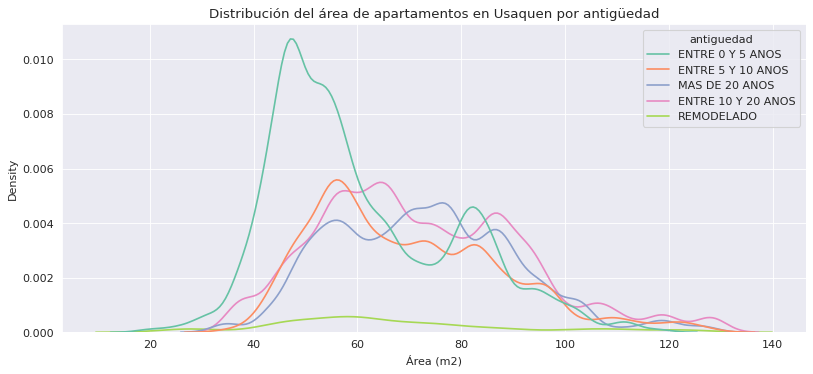

In [26]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='area',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en Usaquen por antigüedad')
plt.xlabel('Área (m2)')
plt.show()

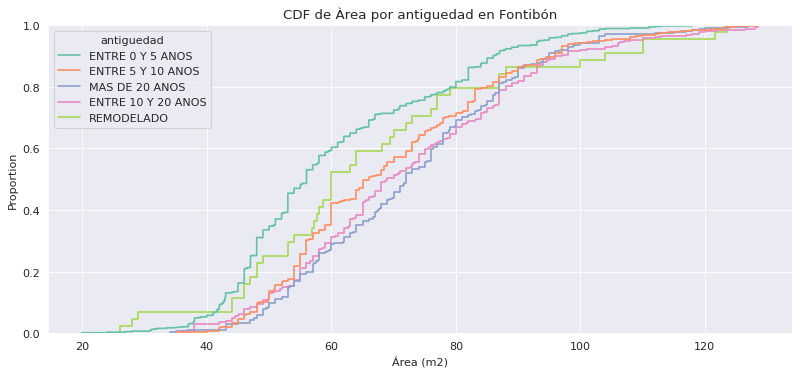

In [27]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='area',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de Àrea por antiguedad en Fontibón')
plt.xlabel('Área (m2)')
plt.show()

Lo apartamentos mas recientes tienden a tener un Àrea menor que los mas antiguos

### Estacion de TM Cercana

In [28]:
estacion_tm_cercana = fontibon[fontibon['is_cerca_estacion_tm'] == True]
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='mean', ascending=False)
estacion_tm_cercana_stats

,count,mean,std,min,25%,50%,75%,max
estacion_tm_cercana,,,,,,,,
El Tiempo - Maloka,69.0,88.7,16.5,58.0,76.0,87.0,94.5,128.6
Modelia,6.0,88.3,7.7,76.0,84.5,90.2,94.5,95.0
AV. Rojas,78.0,83.1,17.7,28.0,73.9,86.0,95.0,123.5
Normandía,24.0,82.8,21.8,29.0,69.2,83.7,95.0,121.0
Salitre - El Greco,1.0,57.8,NaN,57.8,57.8,57.8,57.8,57.8


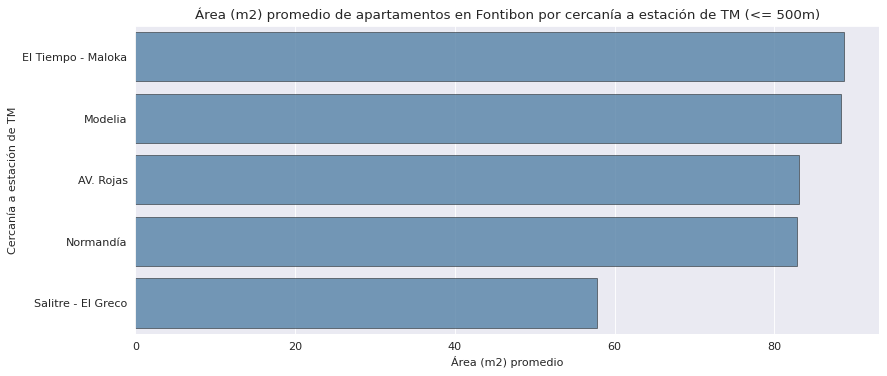

In [29]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='mean',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) promedio de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) promedio')
plt.ylabel('Cercanía a estación de TM')
plt.show()

In [30]:
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='50%', ascending=False)

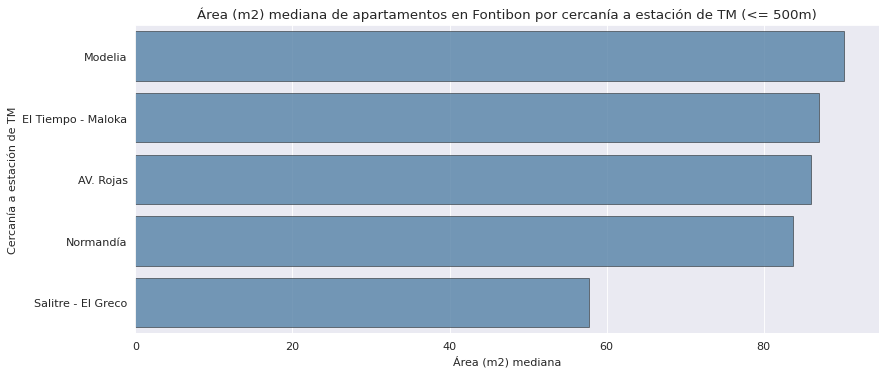

In [31]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='50%',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) mediana de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) mediana')
plt.ylabel('Cercanía a estación de TM')
plt.show()

<Figure size 960x400 with 0 Axes>

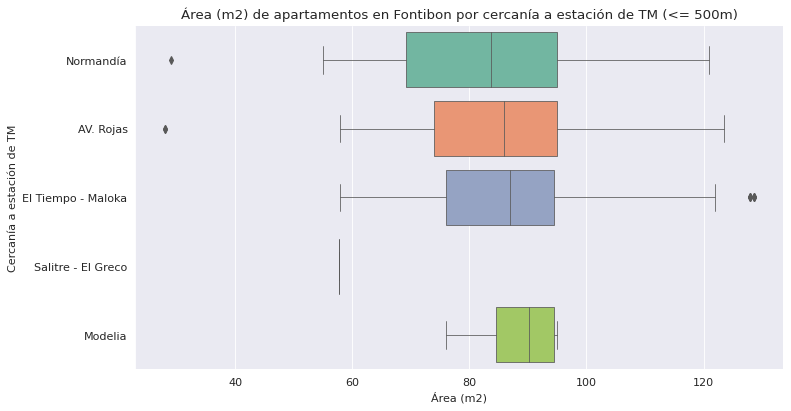

In [32]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='area',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Área (m2) de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2)')
plt.ylabel('Cercanía a estación de TM')
plt.show()

## Precio de venta

In [70]:
fig = px.scatter_mapbox(
    fontibon,
    lat='latitud',
    lon='longitud',
    color='precio_venta',
    size='area',
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    mapbox_style='open-street-map',
    # mapbox_style='dark',
    title='Precio de venta y área de apartamentos en Fontibon',
    hover_name='barrio',
    hover_data=['area', 'precio_venta', 'estrato', 'antiguedad', 'is_cerca_estacion_tm', 'estacion_tm_cercana'],
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title='Precio de venta',
        tickformat='s',
    ),
)

# fig.write_html('../../html/precio_venta_area_fontibon.html')
# guardar como iframe
fig.write_html('../../html/precio_venta_area_fontibon.html', include_plotlyjs='cdn', include_mathjax='cdn')
fig.show()

In [34]:
fontibon.precio_venta.describe().apply(lambda x: humanize.intword(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_venta,1.8 thousand,386.1 million,184.3 million,113.2 million,235.2 million,360.0 million,490.0 million,996.0 million


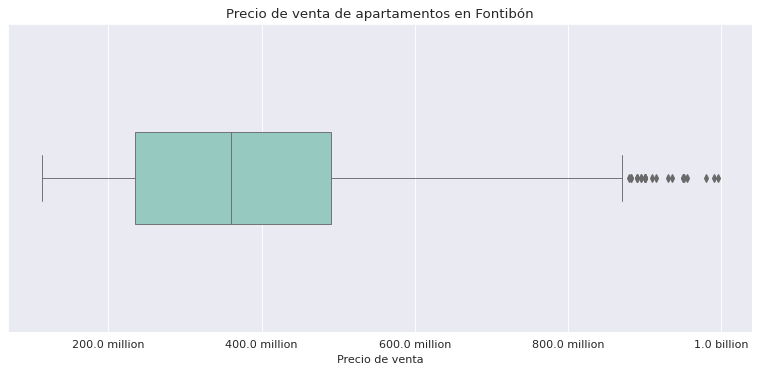

In [35]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    fontibon,
    x='precio_venta',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Fontibón')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

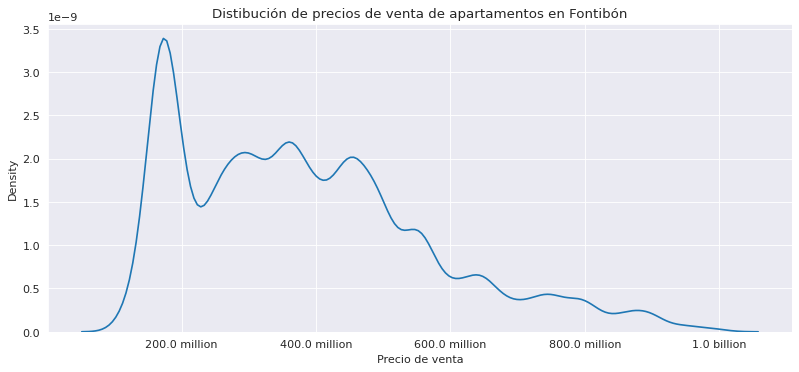

In [36]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distibución de precios de venta de apartamentos en Fontibón')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Barrios

In [37]:
top_barrios = fontibon.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

# escoger los que tienen más de 20 registros para que sea más representativo
top_barrios_mean = top_barrios[top_barrios['count'] > 20].sort_values('mean', ascending=False).head(10)
top_barrios_mean.applymap(lambda x: humanize.intword(x))

,count,mean,median,std
barrio,,,,
LA ESPERANZA NORTE,70,704.3 million,720.0 million,152.9 million
CIUDAD SALITRE OCCIDENTAL,74,634.2 million,607.5 million,163.3 million
CIUDAD SALITRE 3 A. ETAPA,34,629.1 million,636.5 million,129.2 million
CIUDAD SALITRE,95,551.9 million,525.0 million,121.4 million
MODELIA,55,539.4 million,500.0 million,126.6 million
CIUDAD_SALITRE,23,506.4 million,455.0 million,135.9 million
LA ESPERANZA_,130,479.6 million,481.5 million,178.1 million
RINCON DE MODELIA,24,428.6 million,431.5 million,55.4 million
S.C. EL TINTAL CENTRAL,46,428.1 million,450.0 million,66.9 million


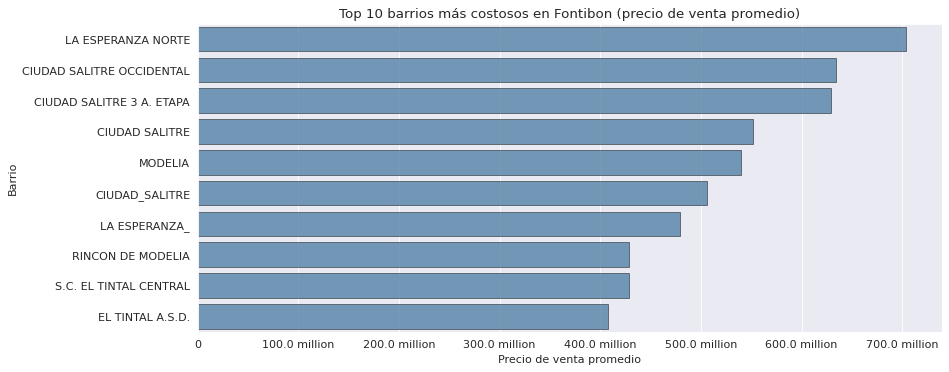

In [38]:
plt.figure(figsize=(12, 5), dpi=80)

sns.barplot(
    top_barrios_mean,
    y=top_barrios_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Fontibon (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [39]:
top_barrios_median = top_barrios[top_barrios['count'] > 20].sort_values('median', ascending=False).head(10)
top_barrios_median.applymap(lambda x: humanize.intword(x))

,count,mean,median,std
barrio,,,,
LA ESPERANZA NORTE,70,704.3 million,720.0 million,152.9 million
CIUDAD SALITRE 3 A. ETAPA,34,629.1 million,636.5 million,129.2 million
CIUDAD SALITRE OCCIDENTAL,74,634.2 million,607.5 million,163.3 million
CIUDAD SALITRE,95,551.9 million,525.0 million,121.4 million
MODELIA,55,539.4 million,500.0 million,126.6 million
LA ESPERANZA_,130,479.6 million,481.5 million,178.1 million
CIUDAD_SALITRE,23,506.4 million,455.0 million,135.9 million
S.C. EL TINTAL CENTRAL,46,428.1 million,450.0 million,66.9 million
RINCON DE MODELIA,24,428.6 million,431.5 million,55.4 million


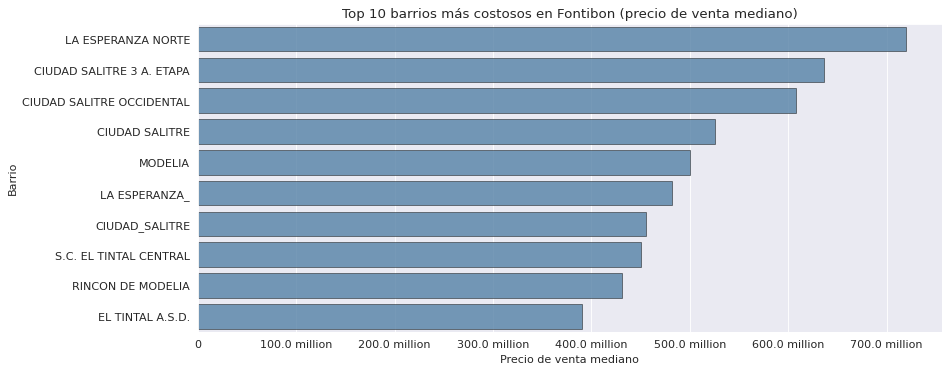

In [40]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_median,
    y=top_barrios_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Fontibon (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [41]:
top_barrios_economicos = fontibon.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

top_barrios_economicos_mean = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('mean', ascending=True).head(10)
top_barrios_economicos_mean.applymap(lambda x: humanize.intword(x))

,count,mean,median,std
barrio,,,,
SAN PABLO JERICO,52,166.7 million,168.0 million,9.6 million
EL CHARCO,140,167.7 million,170.0 million,23.0 million
PRADOS DE LA ALAMEDA,17,176.3 million,174.0 million,8.8 million
S.C. PUENTE GRANDE,44,176.8 million,175.0 million,10.6 million
FERROCAJA_,14,245.2 million,249.0 million,10.7 million
CENTRO FONTIBON,39,269.3 million,272.0 million,64.4 million
URB. CAPELLANIA,19,270.0 million,270.0 million,43.8 million
VILLEMAR,86,272.2 million,270.0 million,70.9 million
URB. LOS HAYUELOS,11,330.5 million,350.0 million,50.6 million


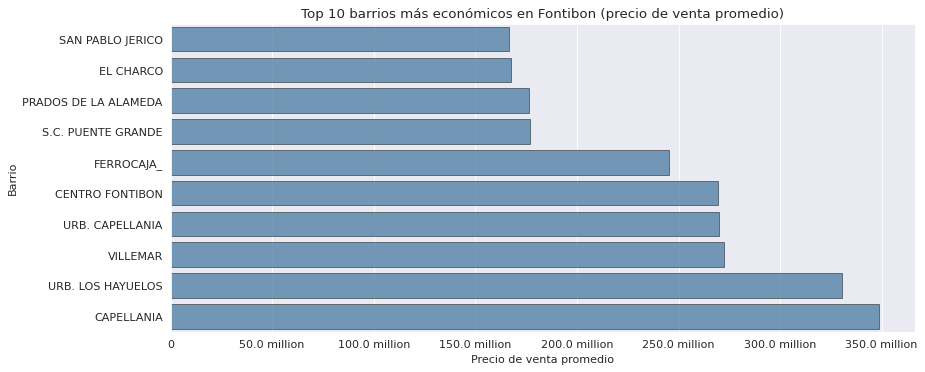

In [42]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_mean,
    y=top_barrios_economicos_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Fontibon (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [43]:
top_barrios_economicos_median = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('median', ascending=True).head(10)
top_barrios_economicos_median.applymap(lambda x: humanize.intword(x))

,count,mean,median,std
barrio,,,,
SAN PABLO JERICO,52,166.7 million,168.0 million,9.6 million
EL CHARCO,140,167.7 million,170.0 million,23.0 million
PRADOS DE LA ALAMEDA,17,176.3 million,174.0 million,8.8 million
S.C. PUENTE GRANDE,44,176.8 million,175.0 million,10.6 million
FERROCAJA_,14,245.2 million,249.0 million,10.7 million
VILLEMAR,86,272.2 million,270.0 million,70.9 million
URB. CAPELLANIA,19,270.0 million,270.0 million,43.8 million
CENTRO FONTIBON,39,269.3 million,272.0 million,64.4 million
CAPELLANIA,59,348.8 million,340.0 million,64.4 million


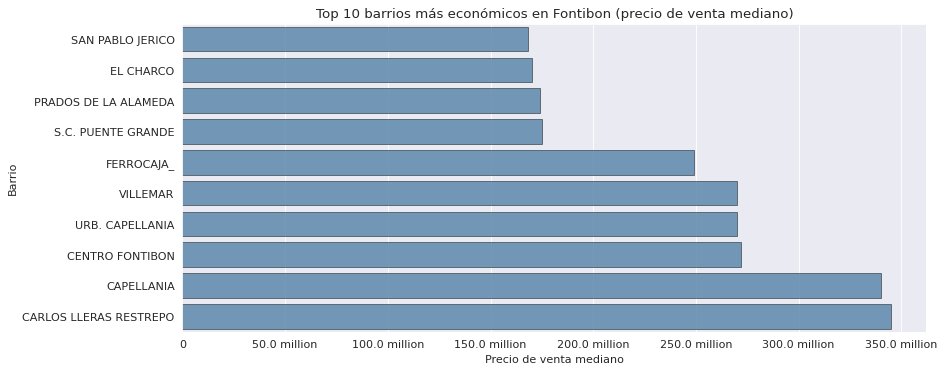

In [44]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_median,
    y=top_barrios_economicos_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Fontibon (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Cercania a Transmilenio

In [45]:
fontibon.groupby('is_cerca_estacion_tm')['precio_venta'].describe().applymap(lambda x: humanize.intcomma(x))

,count,mean,std,min,25%,50%,75%,max
is_cerca_estacion_tm,,,,,,,,
0,"1,605.0","361,852,100.5233645","171,046,386.3481253","113,200,000.0","210,000,000.0","340,000,000.0","455,000,000.0","996,000,000.0"
1,178.0,"604,635,629.258427","152,698,719.88551867","225,775,282.0","485,000,000.0","567,500,000.0","715,000,000.0","980,000,000.0"


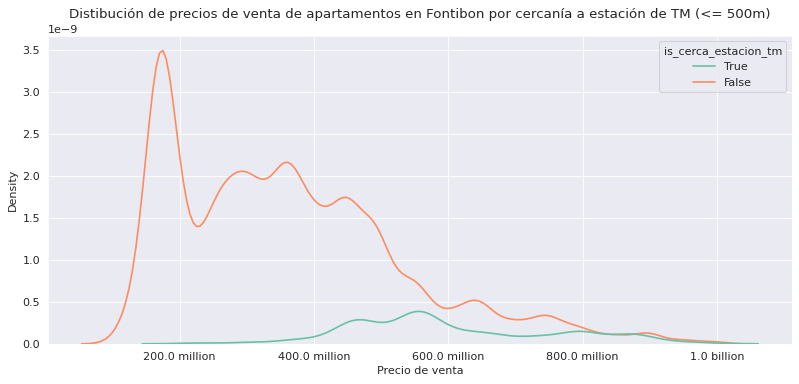

In [46]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='precio_venta',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

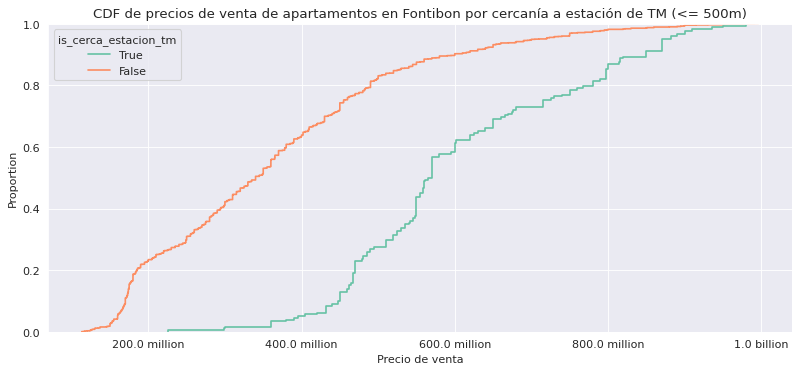

In [47]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estrato

In [48]:
fontibon.groupby('estrato')['precio_venta'].describe().applymap(lambda x: humanize.intword(x))

,count,mean,std,min,25%,50%,75%,max
estrato,,,,,,,,
1.0,1,155.0 million,NaN,155.0 million,155.0 million,155.0 million,155.0 million,155.0 million
2.0,126,165.3 million,24.4 million,116.7 million,155.0 million,170.0 million,174.8 million,285.0 million
3.0,533,243.0 million,94.3 million,130.0 million,175.0 million,210.0 million,282.0 million,750.0 million
4.0,1.0 thousand,452.8 million,138.9 million,113.2 million,360.0 million,440.0 million,520.0 million,996.0 million
5.0,115,710.1 million,151.7 million,260.0 million,602.1 million,740.0 million,815.4 million,990.0 million


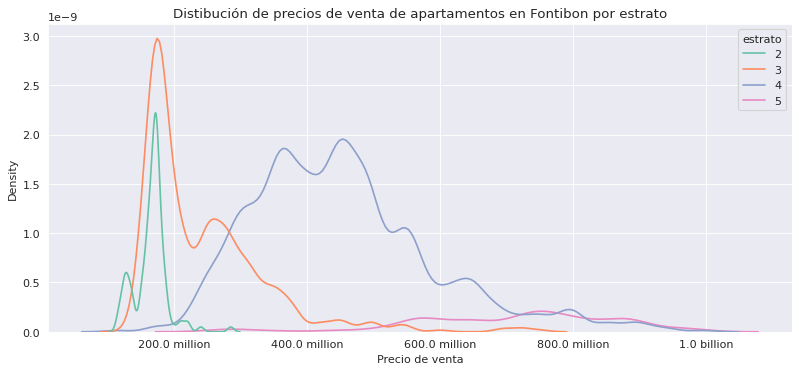

In [49]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='precio_venta',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[2, 3, 4, 5],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Fontibon por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

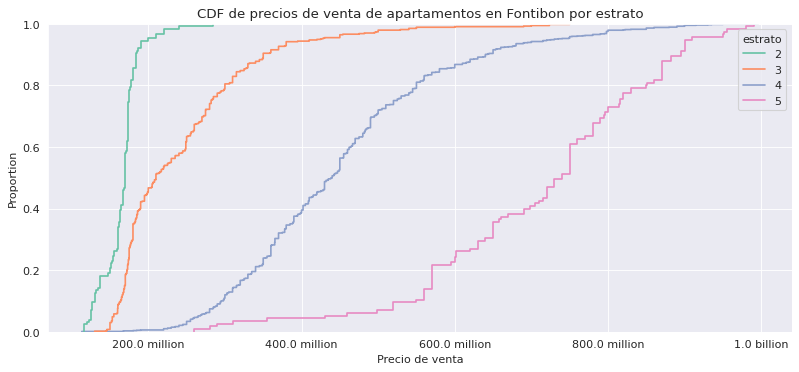

In [50]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='precio_venta',
    hue='estrato',
    hue_order=[2, 3, 4, 5],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Fontibon por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Antiguedad del apartamento

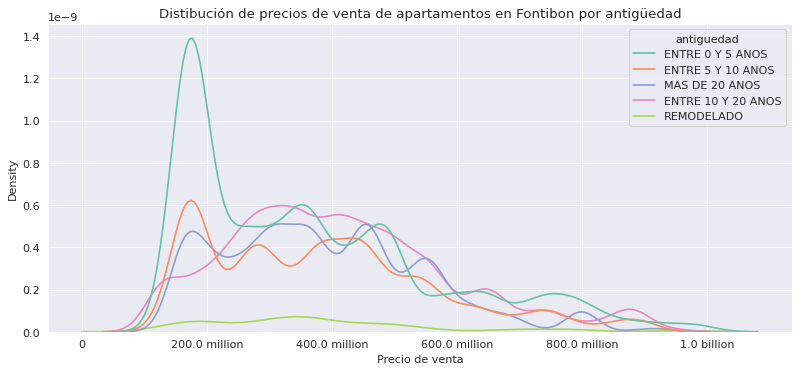

In [51]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon,
    x='precio_venta',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Fontibon por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

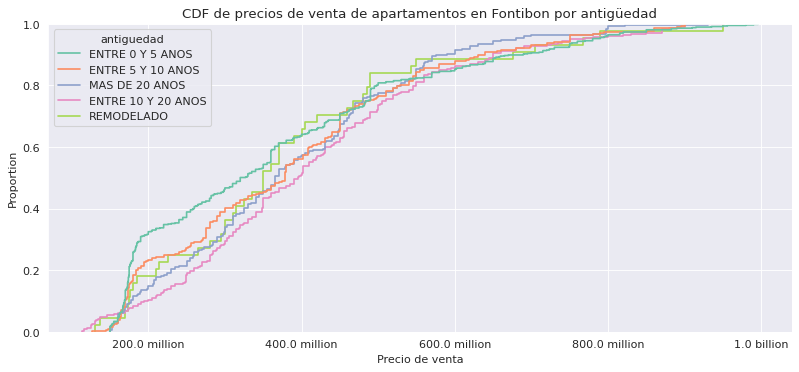

In [52]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    fontibon,
    x='precio_venta',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Fontibon por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estacion de TM Cercana

In [53]:
estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False).applymap(lambda x: humanize.intword(x))

,count,mean,std,min,25%,50%,75%,max
estacion_tm_cercana,,,,,,,,
Salitre - El Greco,1,670.0 million,NaN,670.0 million,670.0 million,670.0 million,670.0 million,670.0 million
Normandía,24,625.6 million,199.7 million,225.8 million,432.0 million,645.0 million,785.0 million,935.1 million
AV. Rojas,78,616.4 million,153.0 million,299.0 million,498.8 million,570.0 million,765.1 million,980.0 million
Modelia,6,598.3 million,107.9 million,380.0 million,626.2 million,635.0 million,647.5 million,665.0 million
El Tiempo - Maloka,69,583.7 million,137.9 million,360.0 million,480.0 million,550.0 million,620.0 million,900.0 million


In [54]:
estacion_tm_cercana_stats_mean = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False)
estacion_tm_cercana_stats_median = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('50%', ascending=False)

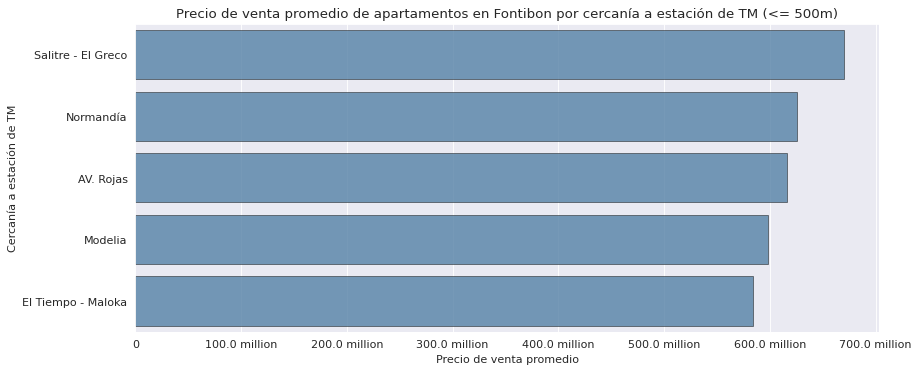

In [55]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_mean,
    y=estacion_tm_cercana_stats_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

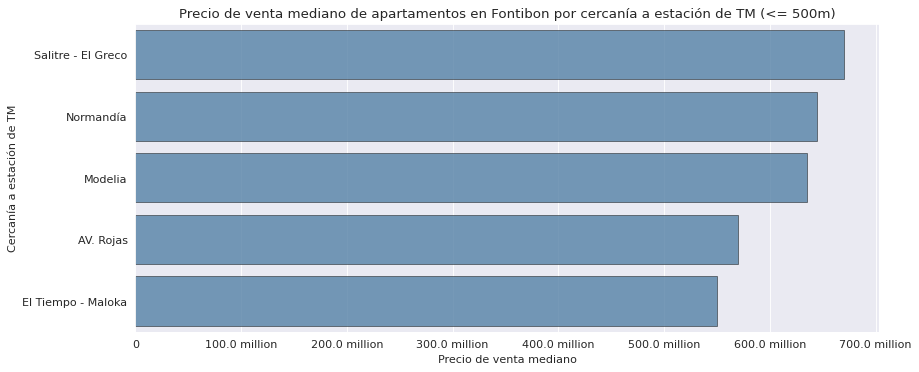

In [56]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_median,
    y=estacion_tm_cercana_stats_median.index,
    x='50%',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta mediano de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

<Figure size 960x400 with 0 Axes>

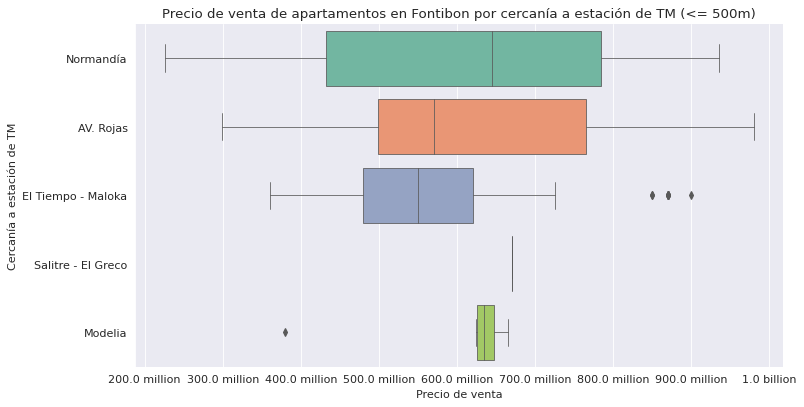

In [57]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='precio_venta',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Precio de venta de apartamentos en Fontibon por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Precios Anteriores Vs Actuales

In [58]:
#selcionar todos los datos qut no tenga la columna precio_venta_anterior nula
fontibon_ant = fontibon[fontibon['precio_venta_anterior'].notna()]
fontibon_ant = fontibon_ant[fontibon_ant['fecha_actualizacion_precio_venta'].dt.month == 10]
fontibon_ant.shape

(47, 39)

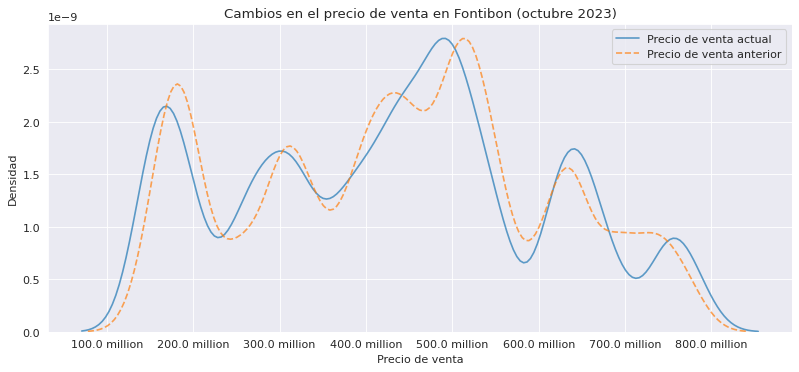

In [59]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    fontibon_ant,
    x='precio_venta',
    bw_adjust=.3,
    label='Precio de venta actual',
    alpha=.7,
)

sns.kdeplot(
    fontibon_ant,
    x='precio_venta_anterior',
    bw_adjust=.3,
    label='Precio de venta anterior',
    alpha=.7,
    linestyle='--',
)

plt.title('Cambios en el precio de venta en Fontibon (octubre 2023)')
plt.xlabel('Precio de venta')
plt.ylabel('Densidad')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.legend()
plt.show()

## Antiguedad

In [60]:
fontibon.antiguedad.value_counts()

antiguedad
ENTRE 0 Y 5 ANOS      563
ENTRE 10 Y 20 ANOS    449
MAS DE 20 ANOS        372
ENTRE 5 Y 10 ANOS     355
REMODELADO             44
Name: count, dtype: int64

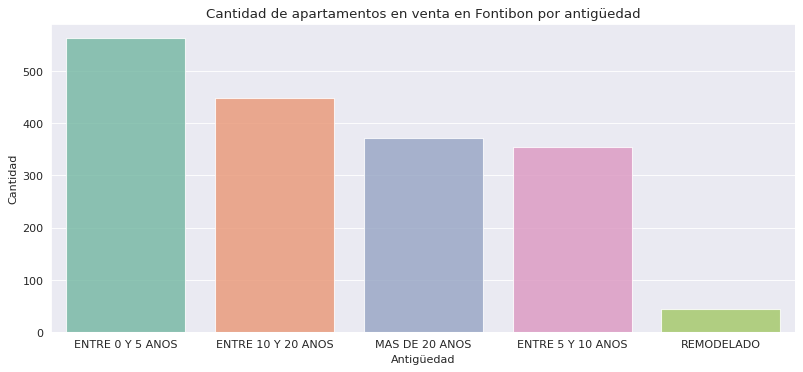

In [61]:
plt.figure(figsize=(12, 5))

sns.countplot(
    fontibon,
    x='antiguedad',
    order=fontibon.antiguedad.value_counts().index,
    palette='Set2',
    # edgecolor='black',
    # linewidth=.5,
    alpha=.8,
)

plt.title('Cantidad de apartamentos en venta en Fontibon por antigüedad')
plt.xlabel('Antigüedad')
plt.ylabel('Cantidad')
plt.show()

### Barrios

In [62]:
fontibon.groupby('antiguedad')['barrio'].describe()

,count,unique,top,freq
antiguedad,,,,
ENTRE 0 Y 5 ANOS,563,50,EL TINTAL A.S.D.,67
ENTRE 10 Y 20 ANOS,449,50,EL TINTAL A.S.D.,84
ENTRE 5 Y 10 ANOS,355,38,EL TINTAL A.S.D.,93
MAS DE 20 ANOS,367,60,CIUDAD SALITRE,69
REMODELADO,44,19,EL TINTAL A.S.D.,7


In [63]:
fontibon.groupby('antiguedad')['area'].describe().apply(lambda x: round(x,1))

,count,mean,std,min,25%,50%,75%,max
antiguedad,,,,,,,,
ENTRE 0 Y 5 ANOS,563.0,60.7,17.6,19.9,47.1,56.0,73.0,118.0
ENTRE 10 Y 20 ANOS,449.0,72.4,19.7,36.0,58.0,69.0,87.0,128.6
ENTRE 5 Y 10 ANOS,355.0,69.7,18.4,35.2,55.0,66.0,82.0,128.0
MAS DE 20 ANOS,372.0,72.7,17.5,34.0,58.0,72.0,85.0,127.0
REMODELADO,44.0,66.5,23.3,26.0,52.0,60.0,77.0,123.5


In [64]:
fontibon.groupby('barrio')['antiguedad'].describe().sort_values(by='count', ascending=False).head(10)

,count,unique,top,freq
barrio,,,,
EL TINTAL A.S.D.,263,5,ENTRE 5 Y 10 ANOS,93
EL CHARCO,140,5,ENTRE 5 Y 10 ANOS,67
LA ESPERANZA_,130,4,ENTRE 0 Y 5 ANOS,53
URB. PRADO GRANDE,120,5,ENTRE 5 Y 10 ANOS,50
CIUDAD SALITRE,95,5,MAS DE 20 ANOS,69
VILLEMAR,86,5,ENTRE 0 Y 5 ANOS,33
CIUDAD SALITRE OCCIDENTAL,74,5,MAS DE 20 ANOS,32
LA ESPERANZA NORTE,70,5,ENTRE 0 Y 5 ANOS,37
CAPELLANIA,59,5,ENTRE 10 Y 20 ANOS,33


### Estrato

In [65]:
fontibon.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('estrato', 'mean'),
    median=('estrato', 'median'),
    std=('estrato', 'std'),
).sort_values(by='count', ascending=False).head(10)

,count,mean,median,std
barrio,,,,
EL TINTAL A.S.D.,263,3.954373,4.0,0.335282
EL CHARCO,140,2.378571,2.0,0.486773
LA ESPERANZA_,130,3.876923,4.0,0.352519
URB. PRADO GRANDE,120,3.991667,4.0,0.242391
CIUDAD SALITRE,95,4.021053,4.0,0.144321
VILLEMAR,86,3.069767,3.0,0.369123
CIUDAD SALITRE OCCIDENTAL,74,4.256757,4.0,0.469941
LA ESPERANZA NORTE,70,4.800000,5.0,0.402888
CAPELLANIA,59,3.915254,4.0,0.336725


## Barrios

In [66]:
fontibon.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10)

,codigo
barrio,
EL TINTAL A.S.D.,263
EL CHARCO,140
LA ESPERANZA_,130
URB. PRADO GRANDE,120
CIUDAD SALITRE,95
VILLEMAR,86
CIUDAD SALITRE OCCIDENTAL,74
LA ESPERANZA NORTE,70
CAPELLANIA,59


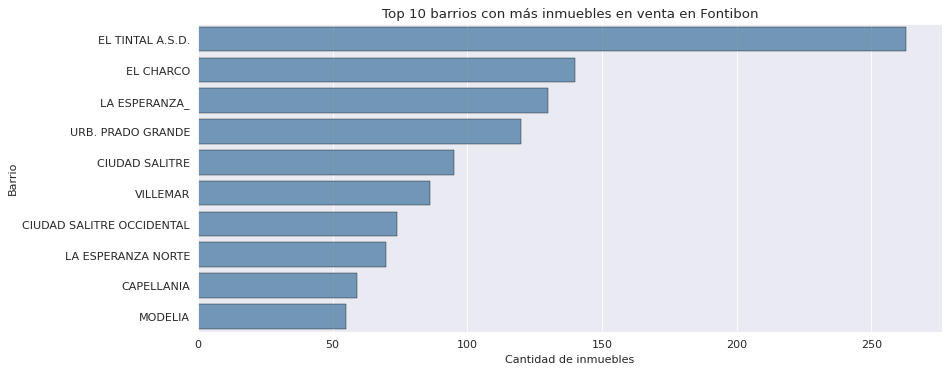

In [67]:
plt.figure(figsize=(12, 5))

sns.barplot(
    data=fontibon.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10),
    x='codigo',
    y=fontibon.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10).index,
    # palette='Set2',
    color='steelblue',
    orient='h',
    edgecolor='black',
    linewidth=.4,
    alpha=.8
)

plt.title('Top 10 barrios con más inmuebles en venta en Fontibon')
plt.xlabel('Cantidad de inmuebles')
plt.ylabel('Barrio')
plt.show()